In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Camera Calibration

### Load up the Points

In [2]:
x = np.loadtxt('./data/2Dpoints.txt')

In [3]:
X = np.loadtxt('./data/3Dpoints.txt')

In [4]:
t1 = np.zeros((2*len(X), 4))
t2 = np.zeros((2*len(X), 4))
b = np.zeros((2*len(X), 4))
for i in range(len(X)):
    xi, yi = x[i]
    t1[i*2] = np.hstack((X[i], [1]))
    t2[i*2+1] = np.hstack((X[i], [1]))
    b[i*2] = np.hstack((-xi*X[i], [-xi]))
    b[i*2+1] = np.hstack((-yi*X[i], [-yi]))

### Create the linear system of equations that give us our projection matrix

In [5]:
A = np.hstack((t1, t2, b))

### Solve the system

In [6]:
ew, ev = np.linalg.eig(A.T @ A)

### Get the minimum eigenvector

In [7]:
p = ev[:,np.argmin(ew)]

### Normalize the vector

In [8]:
p /= np.linalg.norm(p)

### Ensure the norm is 1

In [9]:
np.linalg.norm(p)

1.0

### Rasterize our matrix to get camera

In [10]:
p = p.reshape((3, 4))

### Get 2D projections from our 3D points and camera

In [11]:
out_proj = (p @ np.hstack((X, np.ones((len(X),1)))).T).T

In [12]:
out_proj[:,0] = out_proj[:,0] / out_proj[:,2]
out_proj[:,1] = out_proj[:,1] / out_proj[:,2]

In [13]:
out_proj[0:6,0:2]

array([[455.11721135, 218.94246147],
       [ 30.13364693, 120.16645935],
       [267.03235514, 197.2170615 ],
       [367.09026967, 270.88596624],
       [438.16145045, 407.03110105],
       [271.56540985, 297.53342582]])

We can see that our projected 2D points are slightly off from our original. However we also see some points are so far away that it makes no sense interms of the input domain space. I hypothesize that if we are able to clamp the output to the same space as our input, we might be able to improve our squared error, but how much this would impact the semantics of our operation is unknown.

In [14]:
out_x, out_y = out_proj[:,0], out_proj[:,1]

In [15]:
in_x, in_y = x[:,0], x[:,1]

### Calculate sum of squared distance

In [16]:
ssqe = np.sum((in_x - out_x)**2 + (in_y - out_y)**2)

In [17]:
print(ssqe)

18.747648333155453


## Homography

### Load the points

`The function gets rid of the annoying error that NumPy's loadtxt() cries about.`

In [18]:
def fileprocess(s):
    im1, im2 = [], []
    with open(s) as file:
        for line in file:
            a, b, c, d = line.split(',')
            im1.append([float(a),float(b)])
            im2.append([float(c),float(d)])
    return im1,im2

In [19]:
img1, img2 = fileprocess('./data/homography.txt')

In [20]:
img1, img2 = np.array(img1), np.array(img2)

### Compute $T^a$ and $T^b$

In [21]:
def computeTransform(img):
    x = img[:,0]
    y = img[:,1]

    T = np.zeros((3,3))
    
    s = np.sqrt(2)/ np.mean(np.sqrt((x-x.mean())**2 + (y-y.mean())**2))
    
    T[0] = np.array([s, 0, -s*x.mean()])
    T[1] = np.array([0, s, -s*y.mean()])
    T[2] = np.array([0, 0, 1])
    
    return T, s

In [22]:
Ta, s1 = computeTransform(img1)

In [23]:
Tb, s2 = computeTransform(img2)

### Normalize Data

In [24]:
def normalize(img, s):
    img2 = np.zeros(img.shape)
    x = img[:,0]
    y = img[:,1]
    x = img[:,0] - img[:,0].mean()
    y = img[:,1] - img[:,1].mean()
    img2[:,0] = s*x
    img2[:,1] = s*y
    
    return img2

In [25]:
img1_n = normalize(img1, s1)
img2_n = normalize(img2, s2)

### Compute $\tilde{H}$

In [26]:
x1 = img1_n[:,0]
y1 = img1_n[:,1]

x2 = img2_n[:,0]
y2 = img2_n[:,1]

In [27]:
ht1 = np.zeros((2*len(x1), 3))
ht2 = np.zeros((2*len(x1), 3))
ht3 = np.zeros((2*len(x1), 3))
for i in range(len(x1)):
    ht1[i*2] = np.hstack((x1[i], y1[i], 1))
    ht2[i*2+1] = np.hstack((x1[i], y1[i], 1))
    ht3[i*2] = np.hstack((-x2[i]*x1[i], -y1[i]*x2[i], -x2[i]))
    ht3[i*2+1] = np.hstack((-y2[i]*x1[i], -y1[i]*y2[i], -y2[i]))

In [28]:
AH_bar = np.hstack((ht1, ht2, ht3))

In [29]:
ew2, ev2 = np.linalg.eig(AH_bar.T @ AH_bar)

In [30]:
H_bar = ev2[:,np.argmin(ew2)]

In [31]:
H_bar /= np.linalg.norm(H_bar)

In [32]:
np.linalg.norm(H_bar)

1.0

In [33]:
H_bar = H_bar.reshape((3,3))

### Compute $H$

In [34]:
H = np.linalg.inv(Tb).dot(H_bar).dot(Ta)

### Compute points from image 1 using our $H$

In [35]:
img2_proj = (H.dot(np.hstack((img1, np.ones((len(img1),1)))).T)).T

In [36]:
img2_proj[:,0] = img2_proj[:,0]/img2_proj[:,2]
img2_proj[:,1] = img2_proj[:,1]/img2_proj[:,2]

### Plot computed points

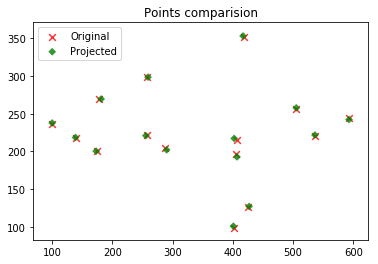

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(img2[:,0], img2[:,1], alpha=0.8, c='red', edgecolors='none', s=45, label='Original', marker='x')
ax.scatter(img2_proj[:,0], img2_proj[:,1], alpha=0.8, c='green', edgecolors='none', s=30, label='Projected', marker='D')
#ax.scatter(solnmx[:,0], solnmx[:,1], alpha=0.8, c='green', edgecolors='none', s=30, label='Projected')
plt.title('Points comparision')
plt.legend(loc=2)
plt.show()

We can notice that the Projected points follow similar trends to our original, just slightly off. I'd hypothesize that instead of doing a DLT if we perform a Least Squares fit, we could improve it slightly, while we're at it, we can compare the results from various other numerical methods for solving GLIS to see which works best.

### Compute sum of squared error

In [38]:
orig_x = img2[:,0]
orig_y = img2[:,1]

proj_x = img2_proj[:,0]
#proj_x = solnmx[:,0]
proj_y = img2_proj[:,1]
#proj_y = solnmx[:,1]

ssqe2 = np.sum((orig_x - proj_x)**2 + (orig_y - proj_y)**2)

In [39]:
print(ssqe2)

105.97387926939517
